In [43]:
from __future__ import annotations
from abc import ABC, abstractmethod
from collections import defaultdict
from dataclasses import dataclass
import graphviz
import itertools
from matplotlib import pyplot as plt
import numpy as np
import random
from pprint import pprint
from typing import (Callable, Dict, Iterable, Generic, Sequence, Tuple,
                    Mapping, TypeVar, Set)

from rl.distribution import (Categorical, Distribution,
                            Gaussian, Choose, Constant)
from rl.markov_process import MarkovProcess, NonTerminal, Terminal, State

## State

State Space: 100 locations on a 10x10 game board.

Transition Probabilities: Equal probability of moving [1,2,3,4,5,6] steps ahead, combined with small probability of taking an additional [3,5,7,10] steps backwards or [2,3,5,7] steps forward. 

In [6]:
@dataclass(frozen=True)
class Die(Distribution[int]):
    sides: int
    def sample(self) -> int:
        return random.randint(1, self.sides)
    
    def expectation(self) -> int:
        return (int + 1) / 2

@dataclass(frozen=True)
class StateSaL:
    position: int
    
@dataclass
class SnakesandLadders(MarkovProcess[StateSaL]):
    # Create a distribution (a 6-sided die)
    six_sided = Die(6)
    snake = Choose([-10,-7,-5,-3])
    ladder = Choose([2,3,5,7])
    
    
    def transition(self, state: NonTerminal[StateSaL]) -> Categorical[State[StateSaL]]:
        die_roll = self.six_sided.sample()
        snake_s = self.snake.sample()
        ladder_s = self.ladder.sample()
        
        return Categorical({
            NonTerminal(StateSaL(state.state.position + die_roll)): 0.60,
            NonTerminal(StateSaL(state.state.position + die_roll + snake_s)): 0.20,
            NonTerminal(StateSaL(state.state.position + die_roll + ladder_s)): 0.20,
        })

## Test

In [7]:
def run_game(time_steps: int, num_traces: int) -> np.ndarray:
    mp = SnakesandLadders()
    start_state_distribution = Constant(NonTerminal(StateSaL(position=0)))
    
    return np.vstack([
        np.fromiter((s.state.position for s in itertools.islice(
            mp.simulate(start_state_distribution),
            time_steps + 1)), float) for _ in range(num_traces)])

In [8]:
game_traces: np.ndarray = run_game(
        time_steps=20,
        num_traces=10
    )

Text(0.5, 1.0, 'Location on Board')

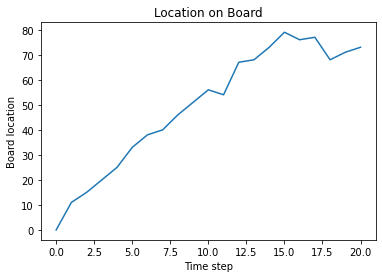

In [10]:
trace1 = game_traces[0]

plt.plot(trace1)
plt.ylabel("Board location")
plt.xlabel("Time step")
plt.title("Location on Board")

## Finite Markov Process

In [151]:
from dataclasses import dataclass
from typing import Mapping, Dict
from rl.distribution import Categorical, FiniteDistribution
from rl.markov_process import FiniteMarkovProcess
from scipy.stats import poisson


@dataclass(frozen=True)
class SaLState:
    position: int

    def get_position(self) -> int:
        return self.position


class SnakesandLaddersFinite(FiniteMarkovProcess[SaLState]):

    def __init__(self, board_size: int,):
        self.size: int = board_size
    
        # See above for Die distribution
        self.distr = Die(6)
        
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> Mapping[SaLState, FiniteDistribution[SaLState]]:
        mymap: Dict[SaLState, Categorical[SaLState]] = {}
        
     
    
        for current_pos in range(self.size):
            current_state = SaLState(current_pos)
            
            # Probabilities just from the die rolls
            die_roll_map: Mapping[SaLState, float] = {
                SaLState(possible_pos): (1/6) * 0.8
                for possible_pos in range(current_pos+1, current_pos + 6)
                
            }
            
            # Probabilities from the snakes and ladders
            snake_and_ladder_map: Mapping[SaLState, float] = {
                SaLState(current_pos + offset): (1/5) * 0.2
                for offset in [-7,-5,-3,7,9] if (current_pos + offset >=0 and current_pos + offset <= self.size)
            }
            
            die_roll_map.update(snake_and_ladder_map)
            
            mymap[SaLState(current_pos)] = Categorical(die_roll_map)
        return mymap
    


# if __name__ == '__main__':
#     si_mp = SnakesandLaddersFinite(board_size=100)

#     print("Transition Map")
#     print("--------------")
#     print(si_mp)

#     print("Stationary Distribution")
#     print("-----------------------")
#     si_mp.display_stationary_distribution()


## Transition Map

In [152]:
Board1 = SnakesandLaddersFinite(board_size=100)

In [ ]:
print("Transition Map")
print("--------------")
print(Board1)

## Histogram

In [167]:
start_dist = Categorical({keys[0]:1})

In [169]:
# This is determining terminal and non-terminal states correctly...
# But trace never seems to exit
#Board1.transition_map

In [170]:
traces = itertools.islice(Board1.traces(start_dist), 100000)

steps_per_trace = []
for trace in traces:
    steps = len(list(trace))
    steps_per_trace += [steps]

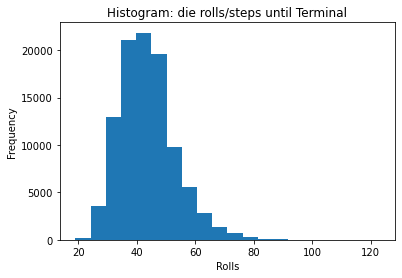

In [179]:
plt.hist(steps_per_trace, bins=20)
plt.title("Histogram: die rolls/steps until Terminal")
plt.ylabel("Frequency")
plt.xlabel("Rolls")
plt.show()